In [1]:
import os
import pyspark

# make sure pyspark tells workers to use python3 not 2 if both are installed
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python'


conf = pyspark.SparkConf()
conf.setMaster("spark://tispark-master:7077")
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.sql.SparkSession.builder \
        .master("spark://tispark-master:7077") \
        .appName("demo-tispark") \
        .config("spark.tispark.pd.addresses", "pd0:2379") \
        .getOrCreate()

In [2]:
import pytispark.pytispark as pti
 
ti = pti.TiContext(spark)
 
ti.tidbMapDatabase("mysql")
 
spark.sql("select count(*) from user").show()

+--------+
|count(1)|
+--------+
|       1|
+--------+



In [3]:
%%time

import random
num_samples = 10000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.range(0, num_samples).filter(inside).count()
pi = 4.0 * count / num_samples
print(pi)

3.1414528
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 2.13 s


In [4]:
%%time

import random
num_samples = 10000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

itr = filter(inside, range(0, num_samples))
pi = 4.0 * sum(1 for _ in itr)/num_samples
print(pi)

3.1419876
CPU times: user 3.49 s, sys: 100 ms, total: 3.59 s
Wall time: 3.65 s


In [5]:
# sc.stop()

### To inject some data into database:

In the `tidb-docker-compose` repo, do:
```shell
$ docker-compose exec tispark-master bash
$ cd /opt/spark/data/tispark-sample-data
$ mysql -h tidb -P 4000 -u root < dss.ddl

```

And update some data if you want:

```sql
UPDATE NATION SET N_COMMENT="Some new words here" WHERE N_NAME="CANADA";
```

Or check the doc here:
https://github.com/pingcap/tidb-docker-compose

### Then view them here on spark:

In [3]:
ti.tidbMapDatabase("TPCH_001")

In [4]:
spark.sql("select count(*) from lineitem").show()

+--------+
|count(1)|
+--------+
|   60175|
+--------+



In [79]:
spark.sql("select * from nation where n_name == 'CANADA'").show(30);

+-----------+------+-----------+-------------------+
|n_nationkey|n_name|n_regionkey|          n_comment|
+-----------+------+-----------+-------------------+
|          3|CANADA|          1|Some new words here|
+-----------+------+-----------+-------------------+



In [39]:
sql_query = \
"""
select O_ORDERDATE, L_SHIPDATE, L_SHIPMODE from orders 
  left join lineitem on orders.O_ORDERKEY = lineitem.L_ORDERKEY
  where orders.O_ORDERDATE == '1996-01-02'
"""
spark.sql(sql_query).toPandas()

,O_ORDERDATE,L_SHIPDATE,L_SHIPMODE
0,1996-01-02,1996-01-30,MAIL
1,1996-01-02,1996-03-30,FOB
2,1996-01-02,1996-04-21,AIR
3,1996-01-02,1996-01-29,REG AIR
4,1996-01-02,1996-04-12,MAIL
5,1996-01-02,1996-03-13,TRUCK
6,1996-01-02,1996-03-03,TRUCK
7,1996-01-02,1996-03-20,FOB
8,1996-01-02,1996-01-08,TRUCK
9,1996-01-02,1996-05-02,MAIL


In [78]:
import matplotlib.pyplot as plt

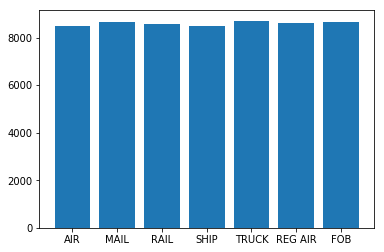

In [77]:
sql_query = \
"""
select count(L_SHIPMODE) as c, L_SHIPMODE from lineitem 
  group by L_SHIPMODE
"""
df = spark.sql(sql_query).toPandas()

fig, ax = plt.subplots()
ax.bar(df.index, df.c)
ax.set_xticks(df.index)
ax.set_xticklabels(df.L_SHIPMODE)
plt.show()

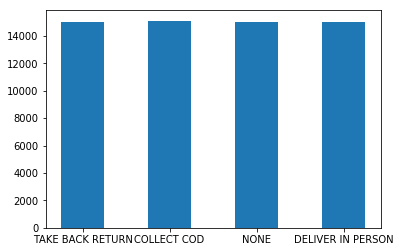

In [76]:
sql_query = \
"""
select count(L_SHIPINSTRUCT) as c, L_SHIPINSTRUCT from lineitem 
  group by L_SHIPINSTRUCT
"""
df = spark.sql(sql_query).toPandas()

bar_width = 0.5

fig, ax = plt.subplots()
ax.bar(df.index, df.c, bar_width)
ax.set_xticks(df.index)
ax.set_xticklabels(df.L_SHIPINSTRUCT)
plt.show()